## ================= Libraries =================

#### Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Folder path

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Proyecto - Deep Learning')

### Libraries

In [ ]:
# Data processing and numerical calculation.
import pandas as pd # Library for data manipulation and analysis.
import numpy as np # Library for numerical calculation in Python.
import random # Module for generating random numbers in Python.

# Image processing.
import cv2 # Library for image processing and computer vision.
import matplotlib.pyplot as plt # Library for data visualization and graphics in Python.
import matplotlib.patches as patches # Module for drawing shapes and objects in graphics.

# Deep learning.
import torch # Library for deep learning in Python.
import torch.nn as nn # Module for neural networks in PyTorch.
import torchvision # Library that provides datasets, transformations, and pre-trained deep learning models for computer vision.
from torchvision import transforms, datasets # Torchvision-specific modules.
from torchvision.models.detection import * # Module for object detection.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Module for object detection.

# Data augmentations.
import albumentations # Library for data augmentation in computer vision.
from albumentations.pytorch.transforms import ToTensorV2 # Converts the augmented image data to a PyTorch tensor format.

# Auxiliary classes.
from image_dataset import ImageDataset
from faster_RCNN import FasterRCNNModel

# Auxiliary functions.
from engine import train_one_epoch, evaluate # Modules with functions for training and evaluating deep learning models.
import utils # Module with utility functions for deep learning.
from xml.etree import ElementTree as et # Module for parsing and manipulating XML documents.

# Hide warnings.
import warnings # Module for controlling warnings in Python.
warnings.filterwarnings('ignore') # Ignore command.

## <br><br><br><br><br> ================= Common functions =================

### Plot image with its bbox

In [ ]:
def plot_img_with_bbox(img, target, title):
  # Size.
  plt.figure(figsize=(8,4))

  # Show image.
  plt.title(title, fontsize=12)
  plt.imshow(img)

  # Iterate for any box.
  for box in (target['boxes']):
    # Get origin point.
    x, y = box[0], box[1]

    # Get width and height of the bbox.
    width, height = box[2]-box[0], box[3]-box[1]

    # Get rectangle of the bbox.
    rect = patches.Rectangle((x, y),
                             width, height,
                             linewidth = 1,
                             edgecolor = 'b',
                             facecolor = 'none')

    # Put bounding box.
    plt.gca().add_patch(rect)

  # Show.
  plt.show()

### Data augmentation

In [ ]:
def get_transform(train=True):
  if train:
    # If we're in the training phase, apply the following transformations:
    return albumentations.Compose([
        # Apply horizontal flip transformation with a random probability between 0.4 and 0.6
        albumentations.HorizontalFlip(p=random.uniform(0.4, 0.6)),
        # Apply shift, scale, and rotate transformation with the following parameters:
        #   - shift_limit: maximum movement of the image
        #   - scale_limit: maximum scale of the image
        #   - rotate_limit: maximum rotation of the image
        #   - p: probability of applying this transformation
        albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.7),
        # Apply the ToTensorV2 transformation with a probability of 20% to convert the image to a tensor
        ToTensorV2(p=0.2),
    # The bbox_params argument specifies the format of the bounding boxes used in the annotations,
    # as well as the name of the field that contains the labels for the boxes.
    # In this case, we're using the 'pascal_voc' format and the 'labels' field.
    ], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']))
  else:
    # If we're in the validation phase, apply only the ToTensorV2 transformation:
    return albumentations.Compose([
        ToTensorV2(p=0.2),
    ], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']))

### Tensor to PIL image

In [ ]:
def tensor_to_PIL_image(img):
    return transforms.ToPILImage()(img).convert('RGB')

## <br><br><br><br><br> ================= Dataset =================

### File path

In [ ]:
detection_training_data_dir = './datasets/detection/training/'
detection_test_data_dir = './datasets/detection/test/'

### Classes

In [ ]:
classes = ['background',
           'apple',
           'orange',
           'banana',
           'coin']

### Get train dataset

In [ ]:
# Observing the dataset without any transformation.
dataset = ImageDataset(files_path=detection_training_data_dir,
                       width=224,
                       height=224,
                       classes=classes)

### Plot image with its bbox (demonstration)

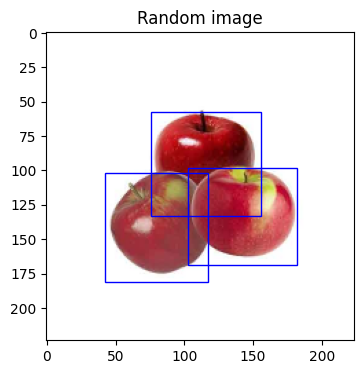

In [ ]:
# Get random image.
img, target = dataset[np.random.randint(0, len(dataset))]

# Plot image with bbox.
plot_img_with_bbox(img, target, 'Random image')

### Parameters

In [ ]:
# Dataset preparation.
image_size = [600, 600]
train_prop = 0.8

# Model.
seed = 18
epochs = 20
num_workers = 4
learning_rate = 0.001
batch_size = 8
num_classes = dataset.num_classes
step_size = 5
gamma = 0.1
momentum = 0.9
weight_decay = 0.0005

### Preparation

In [ ]:
# Create training and testing datasets.
train_dataset = ImageDataset(detection_training_data_dir,
                             image_size[0],
                             image_size[1],
                             classes,
                             transforms=get_transform(train=True))
test_dataset = ImageDataset(detection_test_data_dir,
                            image_size[0],
                            image_size[1],
                            classes,
                            transforms=get_transform(train=False))

# Set random seed for reproducibility.
torch.manual_seed(seed)

### Dataloaders

In [ ]:
# Dataloaderes to load the training and test data of a machine learning model.
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               shuffle=True,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               collate_fn=utils.collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              shuffle=True,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              collate_fn=utils.collate_fn)

<br><br><br><br><br>
## ================= Model (Faster R-CNN) =================

### Set device configuration (GPU or CPU)

In [ ]:
# Get device.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.is_available())

True


### Training configuration

In [ ]:
# Get model.
model = FasterRCNNModel(num_classes=num_classes)

# Move model to device.
model.to(device)

# Get optimizer.
params = [p for p in model.parameters() if p.requires_grad]

# Optimizer (Stochastic Gradient Descent).
optimizer = torch.optim.SGD(params,
                            lr=learning_rate,
                            momentum=momentum,
                            weight_decay=weight_decay)

# Learning rate scheduler.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=step_size,
                                               gamma=gamma)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 80.0MB/s]


### Training

In [ ]:
# Best model.
best_model = None

# Best precision, recall and loss.
best_precision = 0
best_recall = 0
best_loss = np.inf

# Train model.
for epoch in range(epochs):
    # Train.
    train_one_epoch(model,
                    optimizer,
                    train_dataloader,
                    device,
                    epoch,
                    print_freq=10)

    # Evaluate.
    evaluation = evaluate(model, test_dataloader, device=device)

    # Get loss, precision and recall.
    loss = evaluation.coco_eval['bbox'].stats[0]
    precision = evaluation.coco_eval['bbox'].stats[1]
    recall = evaluation.coco_eval['bbox'].stats[2]

    # Update learning rate.
    lr_scheduler.step()

    # Save best model.
    if precision > best_precision:
        best_precision = precision
        best_recall = recall
        best_loss = loss
        best_model = model

    # Save model.
    torch.save(model.state_dict(), './models/model_{}.pth'.format(epoch))

    # Empty cache.
    torch.cuda.empty_cache()

Epoch: [0]  [ 0/41]  eta: 0:10:35  lr: 0.000026  loss: 1.9986 (1.9986)  loss_classifier: 1.6467 (1.6467)  loss_box_reg: 0.3353 (0.3353)  loss_objectness: 0.0090 (0.0090)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 15.4919  data: 6.3127  max mem: 7202
Epoch: [0]  [10/41]  eta: 0:01:25  lr: 0.000276  loss: 1.5411 (1.5105)  loss_classifier: 1.3148 (1.1859)  loss_box_reg: 0.3088 (0.3097)  loss_objectness: 0.0069 (0.0062)  loss_rpn_box_reg: 0.0084 (0.0086)  time: 2.7687  data: 0.6090  max mem: 7360
Epoch: [0]  [20/41]  eta: 0:00:46  lr: 0.000525  loss: 0.7949 (1.0855)  loss_classifier: 0.3709 (0.7662)  loss_box_reg: 0.3081 (0.3058)  loss_objectness: 0.0042 (0.0054)  loss_rpn_box_reg: 0.0077 (0.0081)  time: 1.5335  data: 0.0391  max mem: 7360
Epoch: [0]  [30/41]  eta: 0:00:22  lr: 0.000775  loss: 0.5704 (0.9276)  loss_classifier: 0.2821 (0.6153)  loss_box_reg: 0.2754 (0.2997)  loss_objectness: 0.0042 (0.0051)  loss_rpn_box_reg: 0.0065 (0.0076)  time: 1.5797  data: 0.0393  max mem: 7360
Epoch: 

# Save model

In [ ]:
# Save best model.
torch.save(best_model.state_dict(), './models/best_model.pth')